In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import cv2
from IPython.display import Image
import os
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/Released_Data/'
sub_class = 'sub_classes_mapping.csv'
super_class = 'super_classes_mapping.csv'
train_data = 'train_data.csv'

# Now you can read or manipulate the file
df_subclass = pd.read_csv(file_path+sub_class)
df_superclass = pd.read_csv(file_path+super_class)
df_train = pd.read_csv(file_path+train_data)

# Example: Print the content
df_subclass.head()

,index,class
0,0,"Scotch terrier, Scottish terrier, Scottie"
1,1,"African chameleon, Chamaeleo chamaeleon"
2,2,standard schnauzer
3,3,terrapin
4,4,"great grey owl, great gray owl, Strix nebulosa"


In [4]:
# # Specify the path to the zip file in your Google Drive
# zip_file_path = '/content/drive/MyDrive/Released_Data/train_shuffle.zip'

# # Specify the destination folder for the extracted files
# extracted_folder_path = '/content/drive/MyDrive/'

# # Unzip the file
# !unzip "$zip_file_path" -d "$extracted_folder_path"

In [4]:
test_path = '/content/drive/MyDrive/test_shuffle/'
train_path = '/content/drive/MyDrive/train_shuffle/'

In [5]:
def create_train_df(train_path, df_train):
  column_names = ['image', 'image_val', 'sub_classes', 'super_class']
  file_names = []
  images = []
  subclass = []
  superclass = []
  for train in df_train['image']:
    image_path = os.path.join(train_path, train)
    if os.path.exists(image_path):

      # read image
      image = cv2.imread(image_path)

      # Normalize the image (example: scale pixel values to [0, 1])
      normalized_image = image / 255.0

      # Extract the numeric part from the filename
      val_sub = df_train.loc[df_train['image'] == train, 'subclass_index'].values[0]
      val_sup = df_train.loc[df_train['image'] == train, 'superclass_index'].values[0]

      sub = df_subclass.loc[val_sub]['class']
      sup = df_superclass.loc[val_sup]['class']

      subclass.append(sub)
      superclass.append(sup)
      file_names.append(train)
      images.append(normalized_image)

  return pd.DataFrame(list(zip(file_names, images, subclass, superclass)), columns=column_names)



new_df = create_train_df(train_path, df_train)
new_df.head()

KeyboardInterrupt: ignored

In [23]:
# Function to convert a string representation of a matrix to a NumPy array
def convert_to_array(matrix_string):
    return np.array(matrix_string)

# Apply the conversion function to the entire column
new_df['image_val2'] = new_df['image_val'].apply(convert_to_array)

In [6]:
# Specify the file path within your Google Drive
csv_file_path = '/content/drive/MyDrive/data.csv'

# Write DataFrame to CSV file
new_df.to_csv(csv_file_path, index=False)

NameError: ignored

In [7]:
# Read CSV into DataFrame
df = pd.read_csv(csv_file_path)

In [8]:
df.head(10)

,image,image_val,sub_classes,super_class,image_val2
0,0.jpg,[[[0.65490196 0.61176471 0.64313725]\n [0.494...,"Afghan hound, Afghan",dog,[[[0.65490196 0.61176471 0.64313725]\n [0.494...
1,1.jpg,[[[0.20784314 0.45098039 0.48235294]\n [0.054...,"bald eagle, American eagle, Haliaeetus leucoce...",bird,[[[0.20784314 0.45098039 0.48235294]\n [0.054...
2,2.jpg,[[[0.30980392 0.43137255 0.49019608]\n [0.305...,dowitcher,bird,[[[0.30980392 0.43137255 0.49019608]\n [0.305...
3,3.jpg,[[[0.2627451 0.45490196 0.37647059]\n [0.101...,"Gila monster, Heloderma suspectum",reptile,[[[0.2627451 0.45490196 0.37647059]\n [0.101...
4,4.jpg,[[[0.6 0.53333333 0.57647059]\n [0.627...,"American alligator, Alligator mississipiensis",reptile,[[[0.6 0.53333333 0.57647059]\n [0.627...
5,5.jpg,[[[0.53333333 0.76078431 0.66666667]\n [0.619...,"African chameleon, Chamaeleo chamaeleon",reptile,[[[0.53333333 0.76078431 0.66666667]\n [0.619...
6,6.jpg,[[[0.36078431 0.49411765 0.61176471]\n [0.439...,pelican,bird,[[[0.36078431 0.49411765 0.61176471]\n [0.439...
7,7.jpg,[[[0.47843137 0.4745098 0.51372549]\n [0.505...,"Tibetan terrier, chrysanthemum dog",dog,[[[0.47843137 0.4745098 0.51372549]\n [0.505...
8,8.jpg,[[[0.61960784 0.69803922 0.81960784]\n [0.643...,"bloodhound, sleuthhound",dog,[[[0.61960784 0.69803922 0.81960784]\n [0.643...
9,9.jpg,[[[0.12156863 0.17254902 0.22745098]\n [0. ...,"Afghan hound, Afghan",dog,[[[0.12156863 0.17254902 0.22745098]\n [0. ...


In [11]:
import os
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, train_path, df_train, df_subclass, df_superclass, transform=None):
        self.train_path = train_path
        self.df_train = df_train
        self.df_subclass = df_subclass
        self.df_superclass = df_superclass
        self.transform = transform

        self.file_names = df_train['image'].tolist()

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        file_name = self.file_names[index]
        image_path = os.path.join(self.train_path, file_name)

        # Read image
        image = cv2.imread(image_path)
        normalized_image = image / 255.0

        # Extract subclass and superclass labels
        val_sub = self.df_train.loc[self.df_train['image'] == file_name, 'subclass_index'].values[0]
        val_sup = self.df_train.loc[self.df_train['image'] == file_name, 'superclass_index'].values[0]

        sub = self.df_subclass.loc[val_sub]['class']
        sup = self.df_superclass.loc[val_sup]['class']

        # Apply transformations if provided
        # if self.transform:
        # normalized_image = self.transform(normalized_image)

        # # Add this block to transpose the image dimensions

        # Define a transformation
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        # Apply the transformation
        normalized_image = transform(image)
        normalized_image = normalized_image.permute(2, 1, 0)
        normalized_image = np.array(normalized_image)
        upscaled_image = cv2.resize(normalized_image, (32, 32), interpolation=cv2.INTER_LINEAR)
        image = torch.tensor(upscaled_image)

        return {'image': image, 'subclass': sub, 'superclass': sup}

# Example usage
# Assuming train_path, df_train, df_subclass, and df_superclass are defined
# and train_transform is your desired image transformation
train_dataset = CustomDataset(train_path, df_train, df_subclass, df_superclass)

# # Accessing data in the DataLoader
# for i in range(len(train_dataset)):
#     sample = train_dataset[i]
#     image = sample['image']
#     subclass = sample['subclass']
#     superclass = sample['superclass']

#     # Perform your training/validation/testing logic here
#     print(f"Subclass: {subclass}, Superclass: {superclass}, Image Shape: {image.shape}")

torch.Size([32, 32, 3])


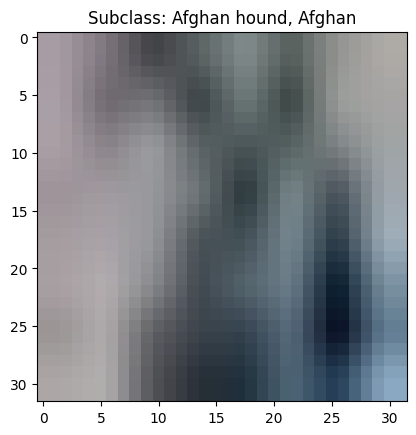

In [12]:
import matplotlib.pyplot as plt
import torch

# Assuming train_dataset is your CustomDataset
# Accessing data for the first sample
sample = train_dataset[0]
image = sample['image']
subclass = sample['subclass']

# Convert the PyTorch tensor to a NumPy array
image = image.permute(1,0,2)
print(image.shape)
image_np = image.numpy()

# Display the image
plt.imshow(image_np)  # Transpose for correct channel order
plt.title(f"Subclass: {subclass}")
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Assuming train_dataset is your CustomDataset
# Split the dataset into training and validation sets
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)

# Define the DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



KeyboardInterrupt: ignored

In [57]:
# Assuming train_loader and val_loader are your DataLoader objects
size_train_loader = len(train_loader)
size_val_loader = len(val_loader)

print(f"Number of batches in training loader: {size_train_loader}")
print(f"Number of batches in validation loader: {size_val_loader}")

batch_size = 32

# Alternatively, if you want to get the number of samples
num_samples_train = size_train_loader * batch_size  # Assuming batch_size is defined
num_samples_val = size_val_loader * batch_size

print(f"Number of samples in training loader: {num_samples_train}")
print(f"Number of samples in validation loader: {num_samples_val}")

Number of batches in training loader: 162
Number of batches in validation loader: 41
Number of samples in training loader: 5184
Number of samples in validation loader: 1312


In [59]:
batch_size = 64
epochs = 200
inChannel = 3
x, y = 32, 32
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [60]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [67]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [68]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0     

In [73]:


autoencoder_train = autoencoder.fit(train_data, train_data, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(val_dataset, val_dataset))

IndexError: ignored

In [74]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: ignored